In [ ]:
https://gestioneval.unibo.it/ 

## Today's programme

- Finish with geographical data, showing extraction of raster data
- Machine Learning, Images and Programming

Yesterday we had taken the nightlights for south Asia.

- Let's use that data at the regional level, and extract nightlight by year by region

It's a complicated exercise - conceptually:

- From an implementation point of view, almost everything is taken care of by package `rasterstats`

To understand it conceptually, we need to understand that a vector can be rewritten in a raster:

- It's what we've done on Tuesday for Italy.

Let's do it for south Asia

In [1]:
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import rasterio
from rasterio.features import rasterize

Import the shapefile of the world adminsitrative boundaries and filter for south Asian countries

In [3]:
# Load the shapefile
shapefile_path = 'world-administrative-boundaries/'
gdf = gpd.read_file(shapefile_path)
gdf = gdf.loc[gdf['name'].isin(['India', 'Pakistan', 'Bhutan', 'Nepal', 'Sri Lanka', 'Bangladesh'])]
print(gdf)

    iso3        status color_code        name continent         region  \
65   LKA  Member State        LKA   Sri Lanka      Asia  Southern Asia   
108  IND  Member State        IND       India      Asia  Southern Asia   
110  BTN  Member State        BTN      Bhutan      Asia  Southern Asia   
160  PAK  Member State        PAK    Pakistan      Asia  Southern Asia   
171  NPL  Member State        NPL       Nepal      Asia  Southern Asia   
249  BGD  Member State        BGD  Bangladesh      Asia  Southern Asia   

    iso_3166_1_ french_shor                                           geometry  
65           LK   Sri Lanka  MULTIPOLYGON (((79.91180 9.02014, 79.89499 8.9...  
108          IN        Inde  MULTIPOLYGON (((93.89941 6.80708, 93.82707 6.7...  
110          BT     Bhoutan  POLYGON ((91.65776 27.76472, 91.65888 27.76333...  
160          PK    Pakistan  POLYGON ((75.32261 32.32444, 75.32654 32.30044...  
171          NP       Népal  POLYGON ((88.14279 27.86605, 88.15248 27.86416.

Let's plot it so we remember how it's done

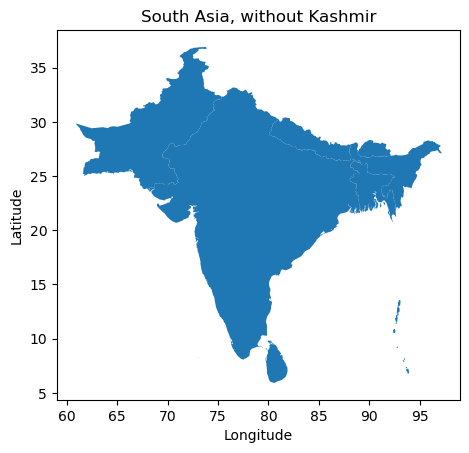

In [5]:
import matplotlib.pyplot as plt
# Create a figure
fig, ax = plt.subplots()
gdf.plot(ax=ax)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('South Asia, without Kashmir')

# Show the plot
plt.show()

Remember the key elements of a raster:

- A matrix of numbers
- An upper west-north point
- A resolution
- A coordinate reference system

We can transform a vector into a raster.

In [27]:
# Define the bounding box and resolution
minx, miny, maxx, maxy = gdf.total_bounds
# Custom ones, can be whatever you want it to be
width = 1500
height = 1500
xres = (maxx - minx) / width
yres = (maxy - miny) / height

Input all of these objects into a transform object:

- It stores all the information about the key elements of a raster, apart from the matrix of numbers and coordinate reference system

Here we use the from bounding box option to create a transform

In [28]:
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)
# Create an empty raster
out_shape = (height, width)

In [29]:
print(transform)

| 0.02, 0.00, 60.87|
| 0.00,-0.02, 36.91|
| 0.00, 0.00, 1.00|


In [30]:
print(out_shape)

(1500, 1500)


Extract the geometries from our vector object

In [31]:
# Extract the geometries
geometry = gdf.geometry.tolist()
print(geometry)

[<MULTIPOLYGON (((79.912 9.02, 79.895 8.987, 79.851 9.001, 79.7 9.081, 79.696...>, <MULTIPOLYGON (((93.899 6.807, 93.827 6.746, 93.811 6.753, 93.785 6.833, 93....>, <POLYGON ((91.658 27.765, 91.659 27.763, 91.659 27.741, 91.654 27.717, 91.64...>, <POLYGON ((75.323 32.324, 75.327 32.3, 75.351 32.276, 75.375 32.264, 75.391 ...>, <POLYGON ((88.143 27.866, 88.152 27.864, 88.188 27.849, 88.187 27.783, 88.14...>, <MULTIPOLYGON (((91.897 21.477, 91.887 21.473, 91.877 21.478, 91.869 21.484,...>]


Rasterize the geometries using all of our metadata - transform them to a matrix

In [32]:
raster = rasterize(
    [(geom, 1) for geom in geometry],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=np.uint8
)
print(raster)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Finally let's look at this matrix

In [33]:
# Convert the raster to a 0-1 matrix
matrix = raster.tolist()

# Print the matrix
for row in matrix:
    print(" ".join(map(str, row)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



As you might remember it from yesterday, this is an image

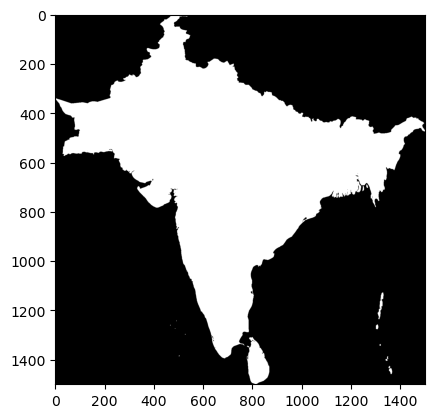

In [34]:
# Plot the raster
plt.imshow(matrix, cmap='gray')
plt.show()

What we will be doing. Is to create subset of the above matrix, with the same resolution and projection as our raster, and multiplying the rasters. 

- Let's compute values for Pakistan

In [35]:
geometry = gdf.loc[gdf['name'] == 'Pakistan'].geometry.tolist()
print(geometry)

[<POLYGON ((75.323 32.324, 75.327 32.3, 75.351 32.276, 75.375 32.264, 75.391 ...>]


This time we convert to a matrix only the shape of Pakistan

In [36]:
raster = rasterize(
    [(geom, 1) for geom in geometry],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=np.uint8
)
print(raster)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [37]:
# Convert the raster to a 0-1 matrix
matrix = raster.tolist()

# Print the matrix
for row in matrix:
    print(" ".join(map(str, row)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



If we had the matrix of numbers corresponding to nightlights, we could just multiply it together.

- Let's take our matrix of nightlights

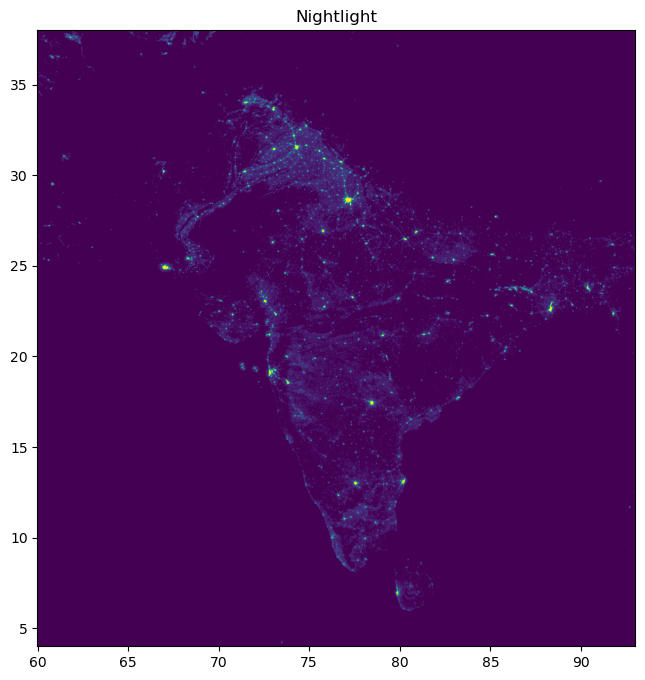

In [38]:
import rasterio.plot as rioplot
fig, ax = plt.subplots(figsize=(8, 8))
nightlight_1992 = rasterio.open('nightlight/1992_cropped.tif')
# Plot the raster
rioplot.show(nightlight_1992, ax=ax)
ax.set_title('Nightlight')
plt.show()

The resolution however, of our two matrixes is going to be very different, such that we cannot multiply them. We can do two things:

- Change the matrix of the raster of nightlight so that it corresponds to the one we used for the vector.
- Recompute the matrix from the vector such that it matches the one of the nightlight raster.

The latter solution is always going to be simpler to do.

In [39]:
print(f'Nightlight data has {nightlight_1992.read(1).shape[0]*nightlight_1992.read(1).shape[1]} pixels')
print(f'The matrix we created has {raster.shape[0]*raster.shape[1]} pixels')

Nightlight data has 16164841 pixels
The matrix we created has 2250000 pixels


So let's reproject our vector into a matrix that shares the same size and resolution as the one of the nightlight data.

- First, we get the transform of the nightlight data
- Second the width and the height

In [42]:
transform

Affine(0.0083333333, 0.0, 59.99583237335,
       0.0, -0.0083333333, 38.00416681464999)

In [40]:
# Define the bounding box and resolution
transform = nightlight_1992.transform
# Create an empty raster
out_shape = (nightlight_1992.height, nightlight_1992.width)

With this information we can now create the matrix where it's 0 everywhere except 1 in Pakistan

In [43]:
raster = rasterize(
    [(geom, 1) for geom in geometry],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=np.uint8
)
raster.shape

(4081, 3961)

Let's check that both our matrixes check:

- Get the matrix from the raster of nightlight
- compare it with the matrix we just created

In [44]:
print(f"Nightlight's matrix is of shape {nightlight_1992.read(1).shape}")
print(f"The reprojected vector corresponding to Pakistan is of shape {raster.shape}")

Nightlight's matrix is of shape (4081, 3961)
The reprojected vector corresponding to Pakistan is of shape (4081, 3961)


Let's have a more precise look at it

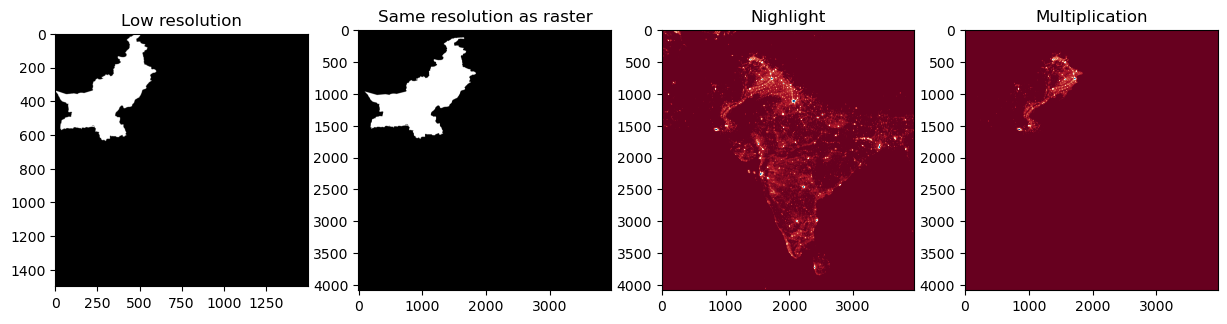

In [46]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 15))

# Plot the raster
ax1.imshow(matrix, cmap='gray')
ax2.imshow(raster, cmap='gray')
ax3.imshow(nightlight_1992.read(1), cmap='RdBu')
ax4.imshow(nightlight_1992.read(1)*raster, cmap='RdBu')
ax1.set_title('Low resolution')
ax2.set_title('Same resolution as raster')
ax3.set_title('Nighlight')
ax4.set_title('Multiplication')
plt.show()

We can multiply the two matrix term by term and we have the value of nightlights for Pakistan

- We'd just need to compute the `mean` to compute nightlight in Pakistan

Let's do it for 1992. Any number of nightlight in Pakistan is multiplied by 1, numbers in India will be multiplied by 0. Then we divide by the number of pixel in Pakistan

In [21]:
import numpy as np
np.sum(raster*nightlight_1992.read(1))/np.sum(raster)

1.9975669258893474

Do it also for 1997

In [49]:
nightlight_1997 = rasterio.open('nightlight/1997_cropped.tif')
np.sum(raster*nightlight_1997.read(1))/np.sum(raster)

2.526405488058409

We move from an average nightlight indicator of `2` to `2.52` between 1992 and 1997. That's about a `25%` increase!

- Let's make sure we computed that right visually.

Restrict Nighlights of 1992 and 1997 to Pakistan and plot them side by side.

In [47]:
from rasterio.mask import mask

# Read the raster file
out_image, out_transform = mask(nightlight_1992, gdf.loc[gdf['name'] == 'Pakistan'].geometry, crop=True)

new_metadata = nightlight_1992.meta.copy()
# Update the metadata with the new dimensions and transform
new_metadata.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save the cropped raster to a new file
cropped_raster_path = 'nightlight/pakistan_1992_cropped.tif'
with rasterio.open(cropped_raster_path, 'w', **new_metadata) as dest:
    dest.write(out_image)

print(f"Pakistan raster saved")

Pakistan raster saved


Now do it for 1997

In [50]:
# Read the raster file
out_image, out_transform = mask(nightlight_1997, gdf.loc[gdf['name'] == 'Pakistan'].geometry, crop=True)

new_metadata = nightlight_1997.meta.copy()
# Update the metadata with the new dimensions and transform
new_metadata.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save the cropped raster to a new file
cropped_raster_path = 'nightlight/pakistan_1997_cropped.tif'
with rasterio.open(cropped_raster_path, 'w', **new_metadata) as dest:
    dest.write(out_image)

print(f"Pakistan raster saved")

Pakistan raster saved


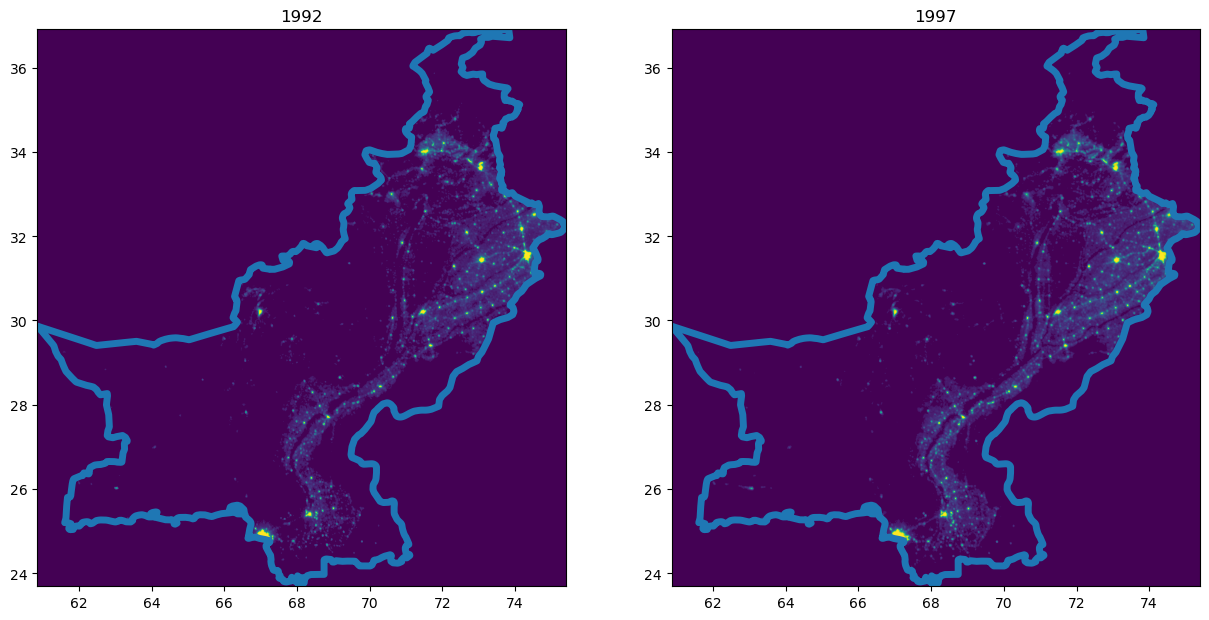

In [53]:
# Get the two rasters
pakistan_1992 = rasterio.open('nightlight/pakistan_1992_cropped.tif')
pakistan_1997 = rasterio.open('nightlight/pakistan_1997_cropped.tif')

# Plot them
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# Plot the raster
rioplot.show(pakistan_1992, ax=ax1)
rioplot.show(pakistan_1997, ax=ax2)
gdf.loc[gdf['name'] == 'Pakistan'].boundary.plot(ax = ax1, linewidth = 5)
gdf.loc[gdf['name'] == 'Pakistan'].boundary.plot(ax = ax2, linewidth = 5)
ax1.set_title('1992')
ax2.set_title('1997')
plt.show()

That's not exactly clear where the increase in nightlight is... Let's plot the difference between the two rasters!

In [ ]:
!pip install cmocean

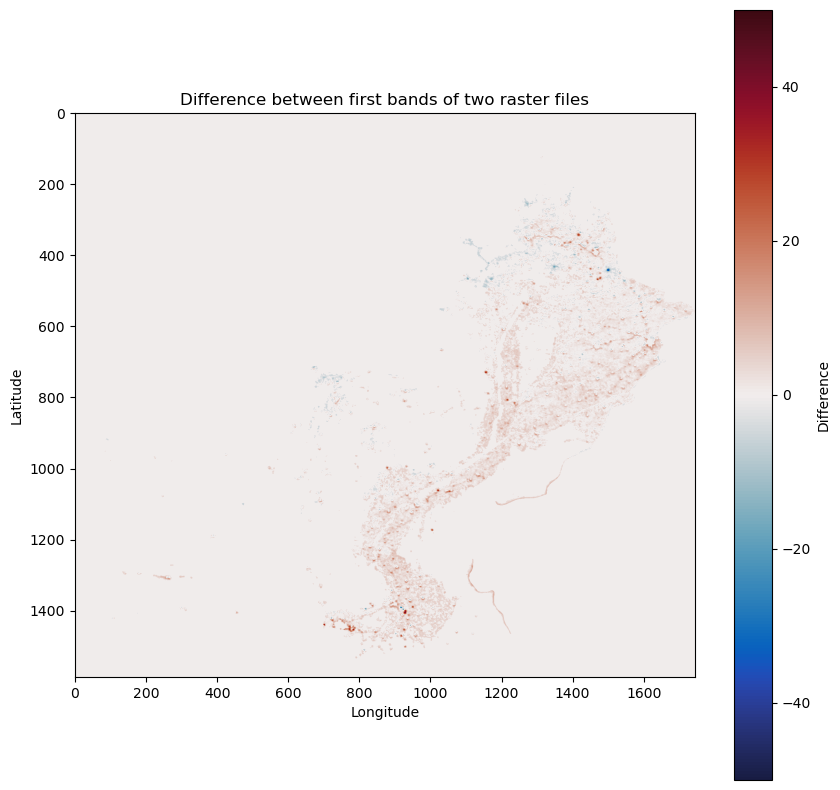

In [54]:
import matplotlib.colors as mcolors
import cmocean

# Make sure you care about the format of your data
difference = pakistan_1997.read(1).astype(np.float32) - pakistan_1992.read(1).astype(np.float32)

# Plot the difference
plt.figure(figsize=(10, 10))
plt.imshow(difference, cmap=cmocean.cm.balance, vmin=-np.max(np.abs(difference)), vmax=np.max(np.abs(difference)))
plt.colorbar(label='Difference')
plt.title('Difference between first bands of two raster files')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

We can also analyse the matrix with all the regular tools that we have to study matrix

In [27]:
print(np.sum(difference)/np.sum(raster))
print(np.min(difference))
print(np.max(difference))

0.5260607091233739
-47.0
50.0


Let's close the connection to the rasters as well

In [55]:
nightlight_1997.close()
pakistan_1992.close()
pakistan_1997.close()

Do we need to do all this by hand (as we just did)?

- The answer is a yes and no...
    - There is a package to do so `rasterstats`, but it is not the fastest - it often crashes the computer
    - If you have to do a lot of different operations with big rasters - you're better off doing what we just did.

Let's use the package `rasterstats` and see how it works.

In [29]:
!pip install rasterstats

With this library, we just need to combine a vector with a raster

- Don't forget to make sure they have the same CRS.

In [56]:
gdf

iso3        status color_code        name continent         region  \
65   LKA  Member State        LKA   Sri Lanka      Asia  Southern Asia   
108  IND  Member State        IND       India      Asia  Southern Asia   
110  BTN  Member State        BTN      Bhutan      Asia  Southern Asia   
160  PAK  Member State        PAK    Pakistan      Asia  Southern Asia   
171  NPL  Member State        NPL       Nepal      Asia  Southern Asia   
249  BGD  Member State        BGD  Bangladesh      Asia  Southern Asia   

    iso_3166_1_ french_shor                                           geometry  
65           LK   Sri Lanka  MULTIPOLYGON (((79.91180 9.02014, 79.89499 8.9...  
108          IN        Inde  MULTIPOLYGON (((93.89941 6.80708, 93.82707 6.7...  
110          BT     Bhoutan  POLYGON ((91.65776 27.76472, 91.65888 27.76333...  
160          PK    Pakistan  POLYGON ((75.32261 32.32444, 75.32654 32.30044...  
171          NP       Népal  POLYGON ((88.14279 27.86605, 88.15248 27.86416...  
249          BD  Bangladesh  MULTIPOLYGON (((91.89749 21.47666, 91.88693 21...

In [30]:
print(gdf.crs)
print(nightlight_1992.crs)

EPSG:4326
EPSG:4326


My computer crashes one of out of two times when I perform this operations - I don't recommend running it

In [ ]:
from rasterstats import zonal_stats
mean_by_country = zonal_stats(gdf, nightlight_1992, stats="mean", affine= transform)

If you have a good computer and a lot of time:

- use `rasterstats`.

If you don't have a good computer, and a lot of time:

- use `R`

If you want don't have time:

- You do it by hand


Let's do it by hand!

For each of our geographic object:

- We compute its matrix equivalent to our nightlight data
- We multiply the two and take the mean for every year of the nightlight data
- We record the information in a dataset

Proceed step by step. First we want a function that takes a row of our `geopandas` and return the matrix.

- To transform a vector into a matrix we need:
    - A shape (width and height)
    - A transform

In [57]:
def transform_geometry_to_matrix(geometry, transform, out_shape):

    raster = rasterize(
        [(geometry, 1)],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=np.uint8
    )
    return(raster)

The shape and the transform:

In [58]:
# Define the bounding box and resolution
transform = nightlight_1992.transform
# Create an empty raster
out_shape = (nightlight_1992.height, nightlight_1992.width)

In [59]:
# Loop over our dataset
list_results = list()
for idx, row in gdf.iterrows():
    
    # Take the country name
    country_name = row['name']
    country_geometry = row.geometry
    
    # Create the matrix
    matrix = transform_geometry_to_matrix(country_geometry, transform, out_shape)
    
    # Compute the average nightlight for this administration
    average_nightlight = np.sum(matrix*nightlight_1992.read(1))/np.sum(matrix)
    
    # store the results
    list_results.append([country_name, average_nightlight])

In [34]:
list_results

[['Sri Lanka', 1.8270898479535125],
 ['India', 2.1467966484743517],
 ['Bhutan', 0.043166823751178134],
 ['Pakistan', 1.9975669258893474],
 ['Nepal', 0.1636831375101047],
 ['Bangladesh', 1.5754720141129708]]

Let's now proceed to repeat this operation for every year:

- The right occasion to introduce the concept of `raster stacks`

Often a raster features multiple `bands`.

- Each `band` is a different matrix
    - But they all share the same metadata (in most cases, not always true for NASA images)
    
- Sometimes `bands` contain information about different years, or different colours.

I stacked all the bands of the nightlight data.

If you go to the metadata of the stack:

- Notice this `count` field, it refers to the number of bands. In our case to the number of years

In [61]:
stacked_data = rasterio.open('south_asia/stacked.tif')
stacked_data.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 4356,
 'height': 3720,
 'count': 23,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0083333333, 0.0, 60.86249903655002,
        0.0, -0.0083333333, 36.91250015234999)}

Each band can be accessed by their number. Two main fields are important `.read` to access the matrix and `.tags`

In [62]:
print(stacked_data.tags(5))

{'name': '1996'}


In [65]:
print(stacked_data.read(22))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [66]:
# Define the bounding box and resolution
transform = stacked_data.transform
# Create an empty raster
out_shape = (stacked_data.height, stacked_data.width)

At this stage, we are left with just one double loop to perform!

In [67]:
import pandas as pd
from tqdm import trange
# Loop over our dataset
list_results = list()
for idx in trange(gdf.shape[0]):
    
    row = gdf.iloc[idx]
    
    # Take the country name
    country_name = row['name']
    country_geometry = row.geometry
    
    # Create the matrix
    matrix = transform_geometry_to_matrix(country_geometry, transform, out_shape)
    
    for ii in range(stacked_data.meta['count']):
        
        # unpack the year
        year = stacked_data.tags(ii+1)['name']
    
        # Compute the average nightlight for this administration
        average_nightlight = np.sum(matrix*stacked_data.read(ii+1))/np.sum(matrix)

        # store the results
        list_results.append([country_name, year, average_nightlight])

# Put the results in a pandas dataset
df = pd.DataFrame(list_results, columns = ['name', 'year', 'nightlight'])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.36s/it]


The result is a dataset ready for analysis and regression

In [68]:
print(df)

           name  year  nightlight
0     Sri Lanka  1992    1.788945
1     Sri Lanka  1993    2.383382
2     Sri Lanka  1994    2.173695
3     Sri Lanka  1995    3.140982
4     Sri Lanka  1996    2.479092
..          ...   ...         ...
133  Bangladesh  2010    2.993965
134  Bangladesh  2011    2.723061
135  Bangladesh  2012    2.884841
136  Bangladesh  2013    2.822773
137  Bangladesh  stac    0.000000

[138 rows x 3 columns]


Then, around these themes, you can imagine pretty much anything, it's all doable in the way we've done:

- Let's say there was an event somewhere:
    - Thunderstorm
    - Earthquake
    - Flood
    
And we want to measure the impact of that earthquake or flood in the surrounding economy.

In 2009 there was devastating earthquake in L'Aquila. Can we observe the damages caused from space?

- Let's first start by identifying the coordinate of the earthquake, with google:
    - 42.3476, 13.3800
    
Let's put that point on the map, and look at nightlight in Italy

In [69]:
# Here are the two rasters. Let's create two side by side maps
italy_stack = rasterio.open('italy/stacked.tif')

# Let's put the point of L'AQUILA on the map
from shapely.geometry import Point

# Hospital
latitude = 42.3476
longitude = 13.3800
point_laquila = Point(longitude, latitude)
laquila = gpd.GeoDataFrame(geometry = [point_laquila])
laquila.crs = "EPSG:4326"
laquila = laquila.to_crs(italy_stack.crs)

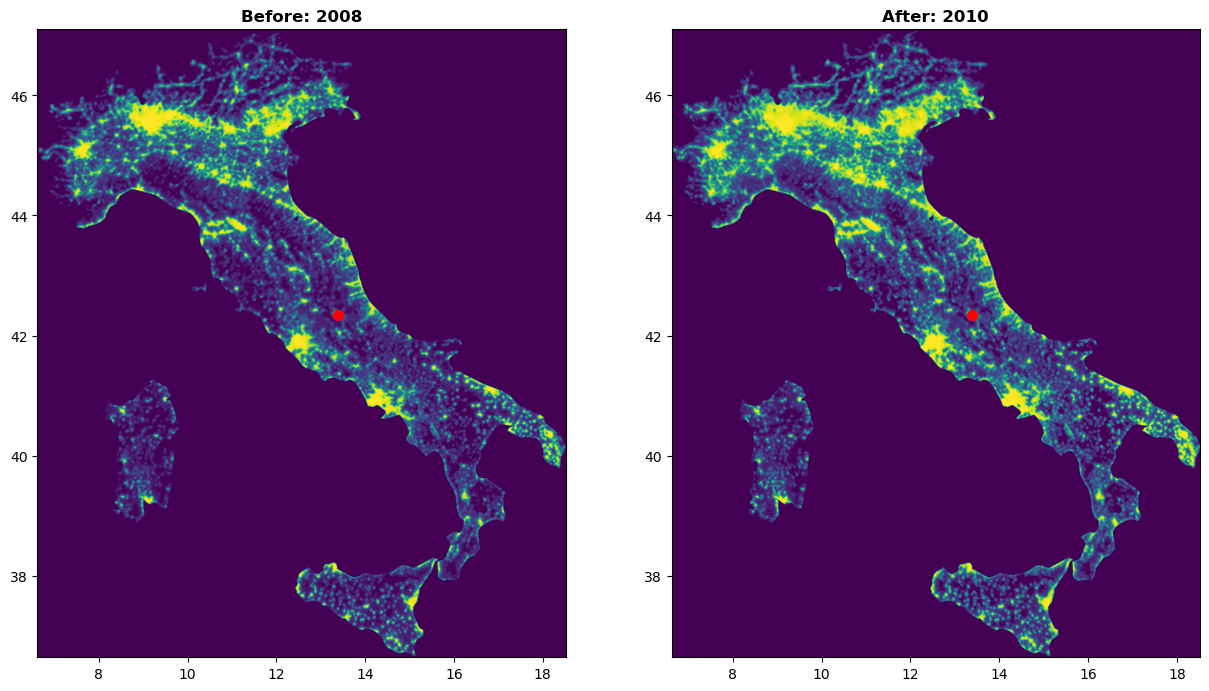

In [72]:
import matplotlib.pyplot as plt
import rasterio.plot as rioplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# Plot the raster
rioplot.show((italy_stack, 17), ax=ax1, title='Before: 2008', zorder = 1)
laquila.plot(ax = ax1, markersize = 50, zorder = 2, marker = 'o', color = 'red')
rioplot.show((italy_stack, 19), ax=ax2, title='After: 2010', zorder = 1)
laquila.plot(ax = ax2, markersize = 50, zorder = 2, color = 'red', marker = 'o')
plt.show()

We need to zoom in a bit

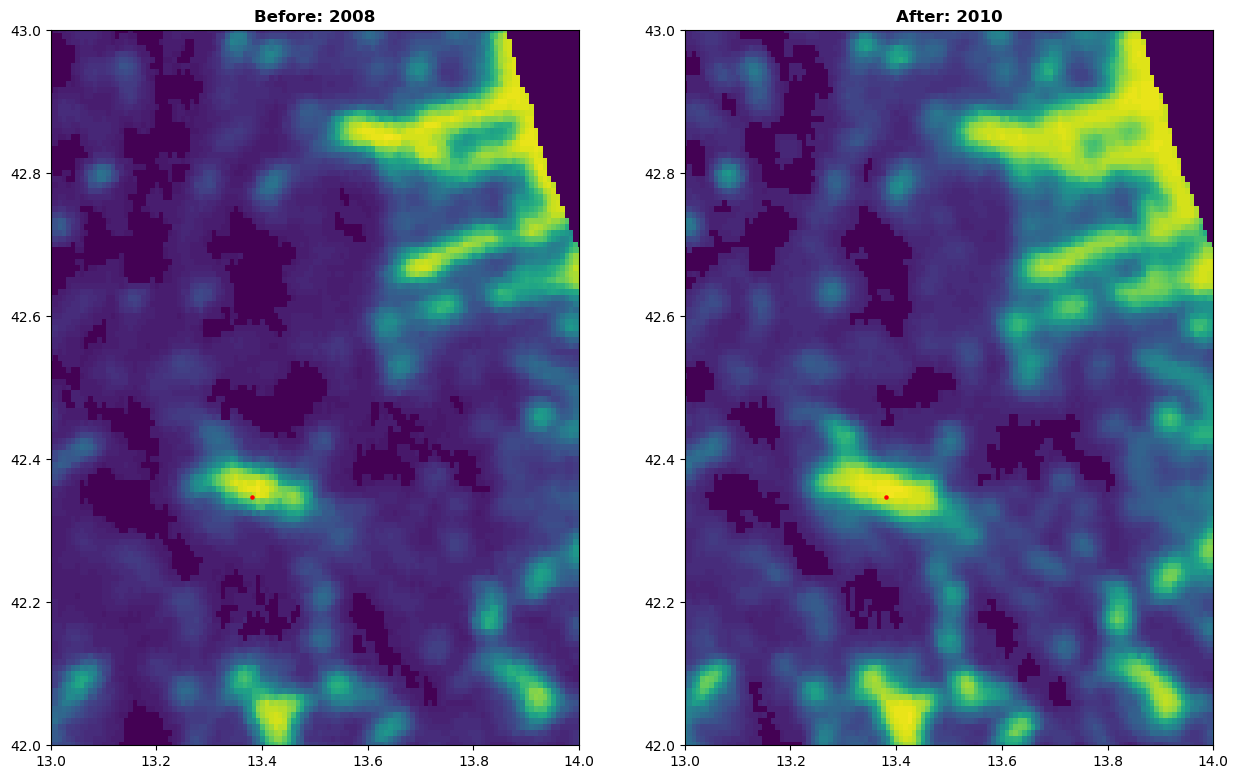

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# Plot the raster
rioplot.show((italy_stack, 17), ax=ax1, title='Before: 2008', zorder = 1)
laquila.plot(ax = ax1, markersize = 5, zorder = 2, marker = 'o', color = 'red')
rioplot.show((italy_stack, 19), ax=ax2, title='After: 2010', zorder = 1)
laquila.plot(ax = ax2, markersize = 5, zorder = 2, color = 'red', marker = 'o')
ax1.set_xlim([13, 14])
ax1.set_ylim([42, 43])
ax2.set_xlim([13,  14])
ax2.set_ylim([42, 43])
plt.show()

How would you measure whether light increased slower in the surroundings of l'Aquila as opposed to the rest of Italy?

If you consider your unit of analysis as a pixel:

- You can artificially increase the sample size by making the pixel ever smaller

If you consider the unit of analysis as groups of pixels:

- That's better, but how do you decide on the size of the group of pixels?

In these situations we would use the shapefiles of provinces/counties:

- The unit of analysis is chosen for us!

But how do we decide which provinces/counties are treated, and which ones aren't?

You would select provinces within a certain radius of your event:
- Test for several possible distances

Take the data for Italian municipalities

In [74]:
italian_shp = gpd.read_file('italy-administrative-boundaries/')
print(italian_shp.crs)
italian_shp = italian_shp.to_crs(italy_stack.crs)

EPSG:3857


Plot the data

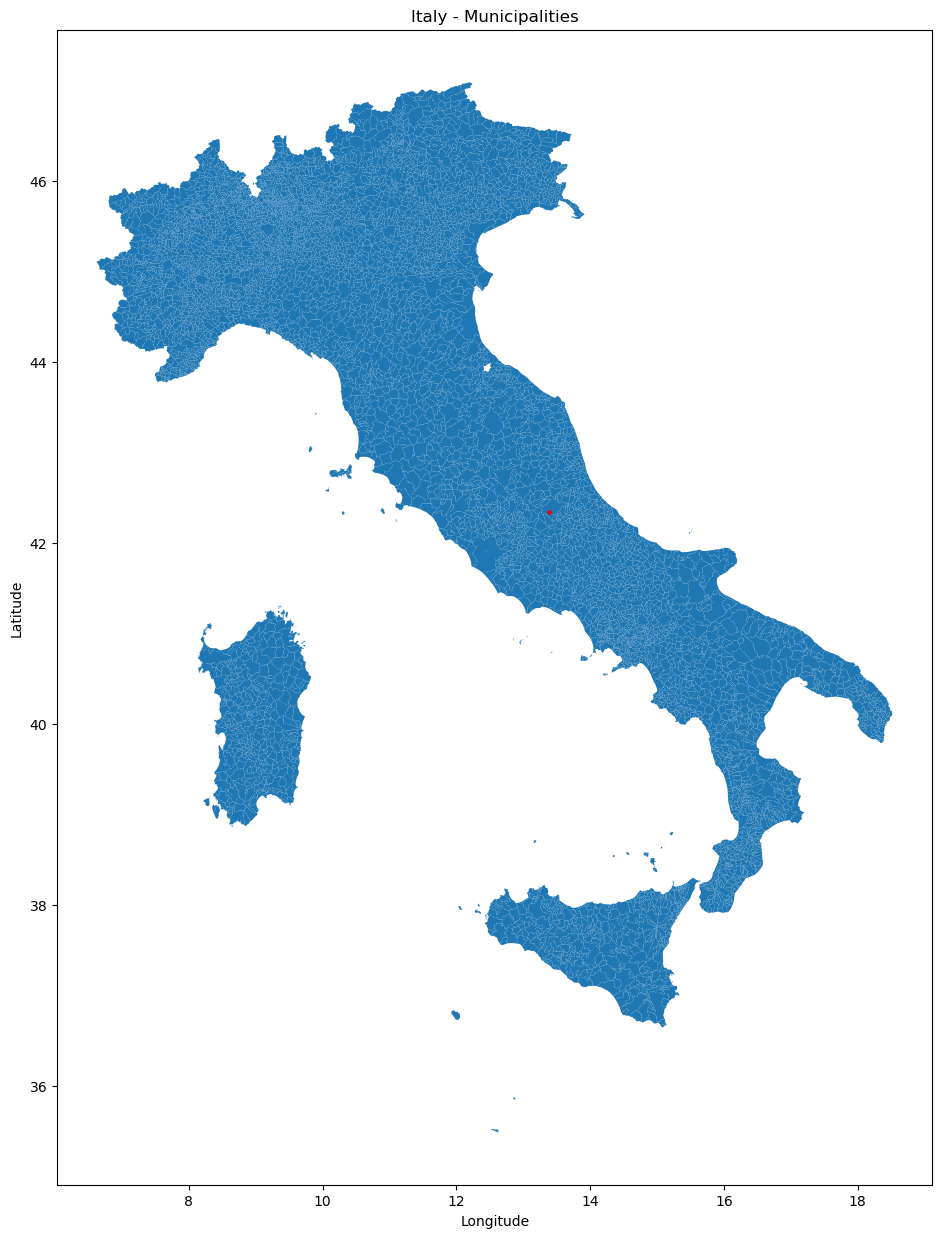

In [75]:
import matplotlib.pyplot as plt
# Create a figure
fig, ax = plt.subplots(figsize=(15, 15))
italian_shp.plot(ax=ax)
laquila.plot(ax=ax, marker = 'o', color = 'red', markersize = 5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Italy - Municipalities')

# Show the plot
plt.show()

Let's create a circle around l'Aquila

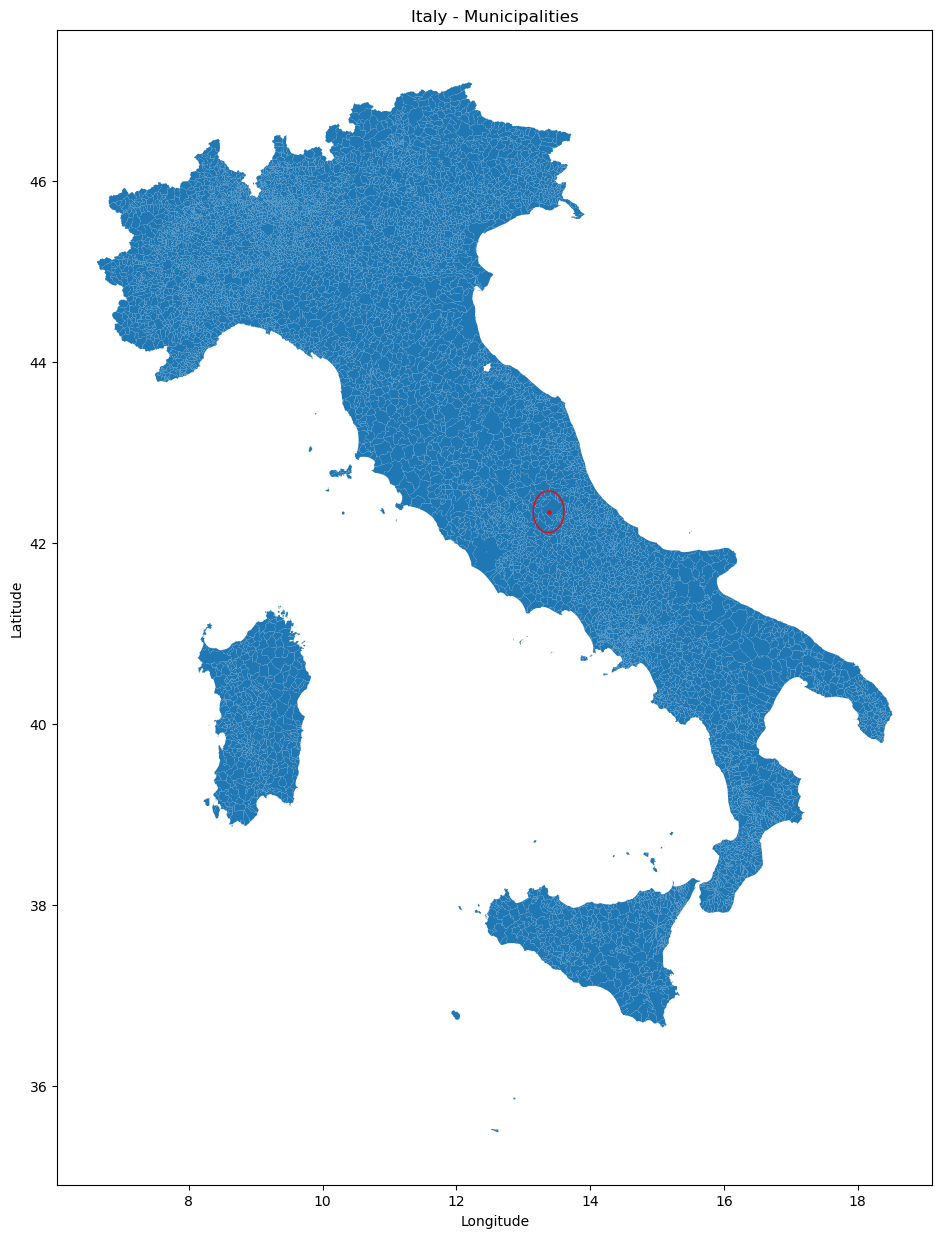

In [78]:
area_hit = gpd.GeoDataFrame(geometry = [point_laquila.buffer(0.23)])
area_hit.crs = "EPSG:4326"
area_hit = area_hit.to_crs(italy_stack.crs)
area_hit_circle = area_hit.boundary


fig, ax = plt.subplots(figsize=(15, 15))
italian_shp.plot(ax=ax)
laquila.plot(ax=ax, marker = 'o', color = 'red', markersize = 5)
area_hit_circle.plot(ax = ax, color = 'red', linewidth = 1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Italy - Municipalities')

# Show the plot
plt.show()

Let's take our dataset of the municipalities, and flag the municipalities that are within this circle.

In [79]:
print(area_hit.crs)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [80]:
print(italian_shp.crs)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [81]:
italian_shp.head(5)

COD_RIP  COD_REG  COD_PROV  COD_CM  COD_UTS  PRO_COM PRO_COM_T  \
0        1        1         1     201      201     1042    001042   
1        1        1         1     201      201     1060    001060   
2        1        1         1     201      201     1076    001076   
3        1        1         1     201      201     1077    001077   
4        1        1         1     201      201     1079    001079   

         COMUNE COMUNE_A  CC_UTS    SHAPE_LENG    Shape_Area  \
0        Burolo     None       0  13222.896787  5.475974e+06   
1  Casalborgone     None       0  24056.822202  2.012501e+07   
2     Chianocco     None       0  21411.076163  1.861335e+07   
3    Chiaverano     None       0  18164.369945  1.202212e+07   
4   Chiesanuova     None       0  10777.398475  4.118911e+06   

                               GlobalID  \
0  428a5371-1203-4014-9d3b-d6f2353a226f   
1  7772511b-1529-4a71-8ed1-7880dc64354a   
2  0f2ee4c5-219c-43dd-ad6e-d8ae5e9f5f7b   
3  16e8325a-c7cd-4b85-ab7d-74216b9d06b3   
4  8ff28d8a-c5f5-4214-afa0-999d470cf9c8   

                                            geometry  
0  POLYGON ((7.93812 45.49086, 7.93832 45.49221, ...  
1  POLYGON ((7.91362 45.15298, 7.91356 45.15300, ...  
2  POLYGON ((7.18303 45.19351, 7.18262 45.19391, ...  
3  POLYGON ((7.90330 45.52628, 7.90305 45.52637, ...  
4  POLYGON ((7.65285 45.42981, 7.65255 45.42989, ...

In [82]:
# Get the earthquake radius polygon (assuming there's only one)
earthquake_radius = area_hit.geometry.iloc[0]

# You can add a flag to the original municipalities DataFrame
italian_shp['touched_by_earthquake'] = italian_shp.intersects(earthquake_radius)

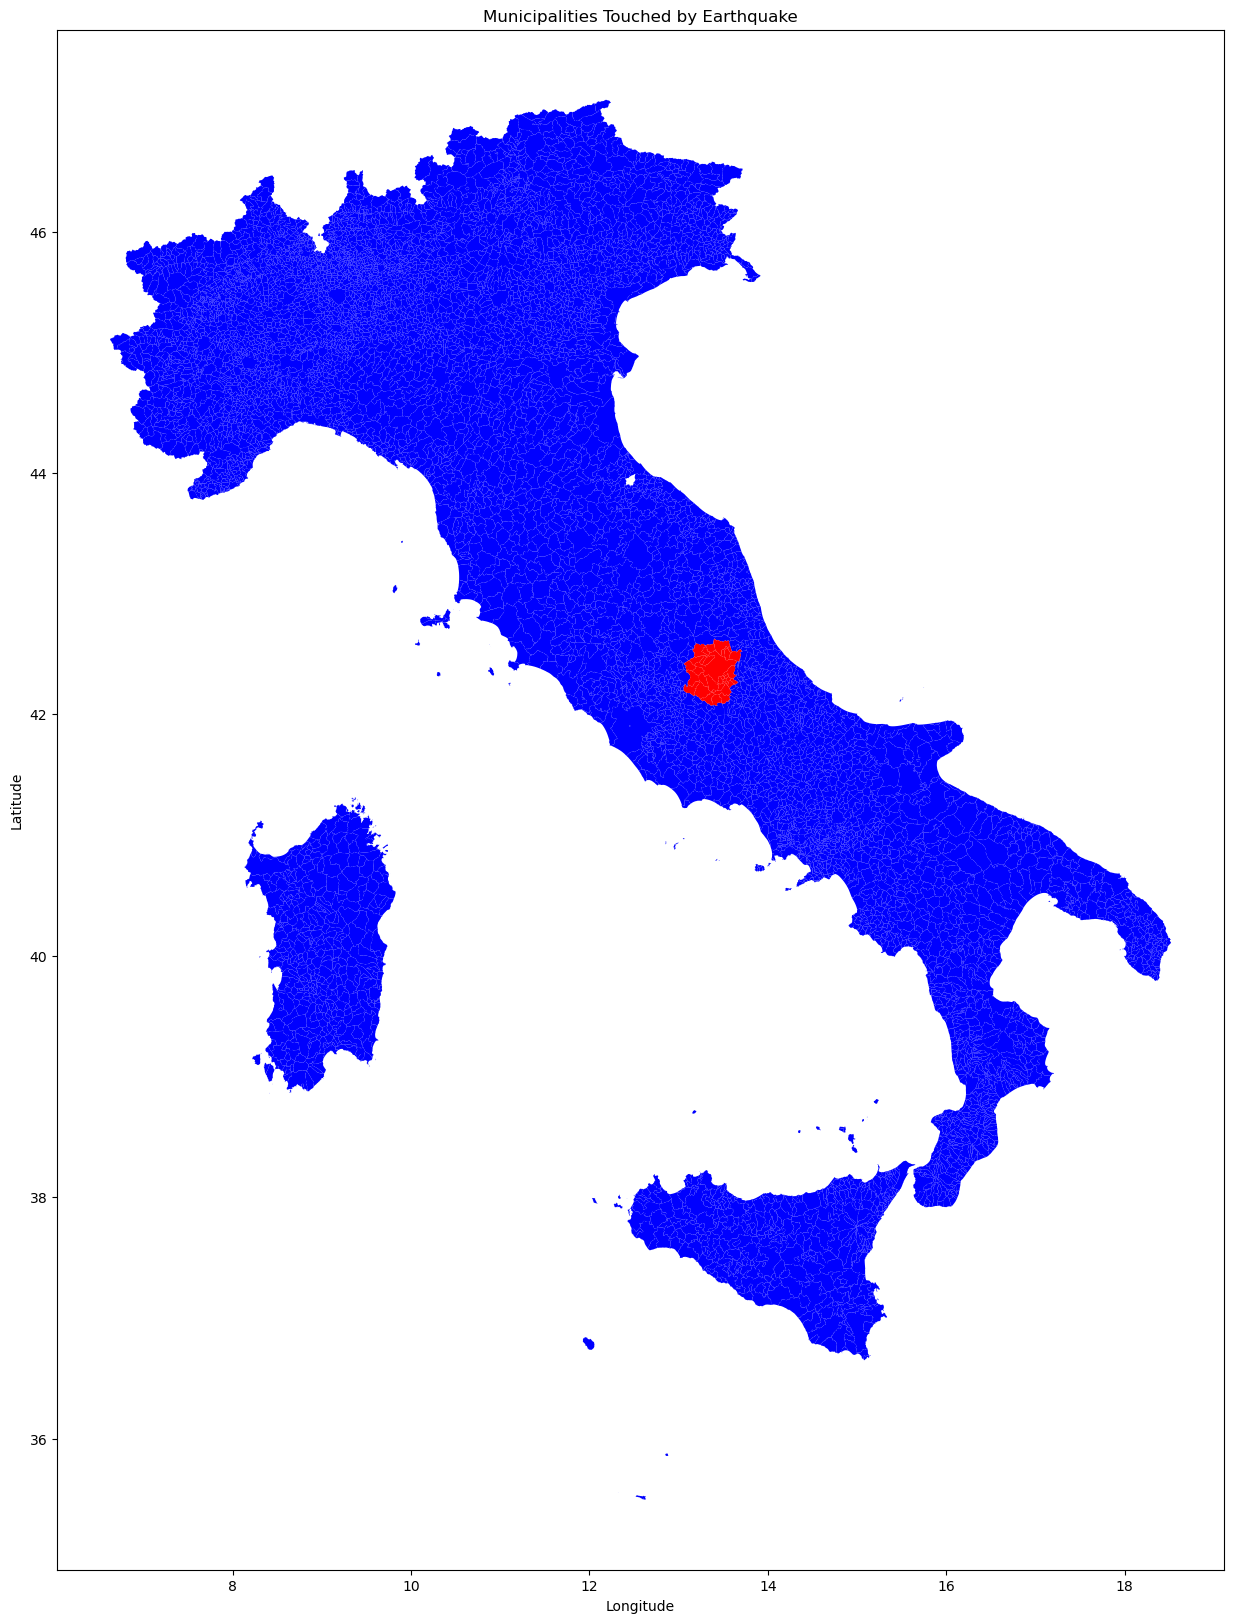

In [106]:
# Plot the municipalities
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the municipalities that are not touched in blue
italian_shp[~italian_shp['touched_by_earthquake']].plot(ax=ax, color='blue')

# Plot the municipalities that are touched in red
italian_shp[italian_shp['touched_by_earthquake']].plot(ax=ax, color='red')  

# Set title and axes labels
ax.set_title('Municipalities Touched by Earthquake')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

Now we just need to extract nightlight in 2008 for each municipality. In 2010 in each municipality. Regress and use the variable "touched_by_earthquake" as our treatment variable.

- Import raster data on nightlight in Italy

We will want to reperform our loop

In [104]:
# Define the bounding box and resolution
transform = italy_stack.transform
# Create an empty raster
out_shape = (italy_stack.height, italy_stack.width)

Let's redo our loop to import data for each municipality

In [105]:
from tqdm import trange
# Loop over our dataset
list_results = list()
for idx in trange(len(italian_shp)):
    
    row = italian_shp.loc[idx]
    
    # Take the country name
    municipality = row['COMUNE']
    municipality_geometry = row.geometry
    
    # Create the matrix
    matrix = transform_geometry_to_matrix(municipality_geometry, transform, out_shape)
    
    # Compute the average nightlight for this administration
    average_nightlight_2008 = np.sum(matrix*italy_stack.read(17))/np.sum(matrix)
    average_nightlight_2010 = np.sum(matrix*italy_stack.read(19))/np.sum(matrix)
    
    # store the results
    list_results.append([municipality, 2008, average_nightlight_2008])
    list_results.append([municipality, 2010, average_nightlight_2010])

# Put the results in a pandas dataset
df = pd.DataFrame(list_results, columns = ['municipality', 'year', 'nightlight'])

 92%|██████████████████████████████████████████████████████████████████████▋      | 7281/7926 [01:08<00:06, 105.05it/s]C:\Users\anato\AppData\Local\Temp\ipykernel_6804\685299111.py:16: RuntimeWarning: invalid value encountered in scalar divide
  average_nightlight_2008 = np.sum(matrix*italy_stack.read(17))/np.sum(matrix)
C:\Users\anato\AppData\Local\Temp\ipykernel_6804\685299111.py:17: RuntimeWarning: invalid value encountered in scalar divide
  average_nightlight_2010 = np.sum(matrix*italy_stack.read(19))/np.sum(matrix)
100%|█████████████████████████████████████████████████████████████████████████████| 7926/7926 [01:14<00:00, 106.16it/s]


We have our dataset, we simply need to add which municipalities were hit by the earthquake, and we you can proceed to do some regressions

In [108]:
# Perform the merge
earthquake_flag = italian_shp[['COMUNE', 'touched_by_earthquake']]
df = pd.merge(df, earthquake_flag, how = "left", left_on = "municipality", right_on = "COMUNE")

### A bit about machine learning

I wish we had the time to do more, but it's clear I won't be able to do so much.

Fortunately, you'll find lots of amazing ressources online!

- I would start with two youtube videos that convey the intuition:
    - https://www.youtube.com/watch?v=aircAruvnKk&ab_channel=3Blue1Brown
    - https://www.youtube.com/watch?v=IHZwWFHWa-w&t=446s
 
These two videos give incredible intuitions of what is a neural network.

For a thorough class on machine learning to become a state of the art coder you should follow the online class on:

- https://course.fast.ai/

Fastai is an online class series of an incredibile quality that brings you to the frontier in about 1 week of work.

And now you have the basis knowledge to follow the class!

Today, we will roughly follow what the first class of fastai is about, hopefully motivating you into following their class

What is machine learning?

- More often than not, when we think of machine learning, we think of neural networks.

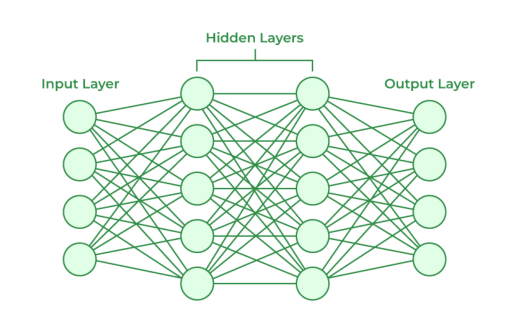

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your PNG file
png_path = 'neural-network1.png'

# Load and display the image
img = mpimg.imread(png_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

We call it neural network because it's supposed to loosely reproduce how sentient beings perceive.

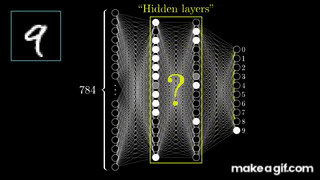

In [223]:
from IPython.display import Image
# Display the GIF in the Jupyter Notebook
Image(filename="But_what_is_a_neural_network_Chapter_1_Deep_learning.gif", width=800, height=600)

What is it that we do as machine learning designers?

- For this part of the class we'll focus on supervised learning.
- There are labels inputs, and we hope the machine understands by itself how to find the label.

Nowadays, you don't actually create neural networks anymore:

- There exists forms of neural networks that were found and seem to work much better than others.

When it comes to machine learning and economics:

- A lot of the work goes into having a dataset that's properly formatted.
- Your work is to understand what off the shelf model is best suited to your needs.
- You would then retrain a model that has already been trained with a particular sample you have.


Let's train a machine learning algorithm to recognize if a picture has a bird in it. - following `fastai` classes and packages

In [230]:
!pip install fastai

   ---------------------------------------- 0.0/232.7 kB ? eta -:--:--
   ------------------- -------------------- 112.6/232.7 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 232.7/232.7 kB 4.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/71.5 kB ? eta -:--:--
   ---------------------------------------- 71.5/71.5 kB 4.1 MB/s eta 0:00:00


Before using fastai, we need to download images from the internet, we'll use duckduckgo

In [231]:
!pip install duckduckgo-search

     ---------------------------------------- 0.0/50.9 kB ? eta -:--:--
     ---------------------------------------- 50.9/50.9 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/138.8 kB ? eta -:--:--
   ---------------------------------------- 138.8/138.8 kB 8.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.6 MB 6.3 MB/s eta 0:00:01
   --------- ------------------------------ 0.6/2.6 MB 6.1 MB/s eta 0:00:01
   -------------- ------------------------- 0.9/2.6 MB 7.4 MB/s eta 0:00:01
   -------------------- ------------------- 1.3/2.6 MB 6.9 MB/s eta 0:00:01
   ------------------------ --------------- 1.6/2.6 MB 7.2 MB/s eta 0:00:01
   ------------------------------ --------- 2.0/2.6 MB 6.9 MB/s eta 0:00:01
   ------------------------------------- -- 2.4/2.6 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 7.1 MB/s eta 0:00:00


We build a small function that returns URL of pictures given a keyword we give

In [119]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        # generator which yields dicts with:
        {'title','image','thumbnail','url','height','width','source'}
        search_results = ddgs.images(keywords=term)       
        # grap number of max_images urls
        image_urls = [result.get("image") for result in search_results[:max_images]]  
        # convert to L (functionally extended list class from fastai)
        return L(image_urls)

In [115]:
with DDGS() as ddgs:
    # generator which yields dicts with:
    # {'title','image','thumbnail','url','height','width','source'}
    search_results = ddgs.images(keywords="bird photos")   

In [117]:
with DDGS() as ddgs:
    # generator which yields dicts with:
    # {'title','image','thumbnail','url','height','width','source'}
    search_results = ddgs.images(keywords="bird")       

In [121]:
search_images("bird", 1)

Searching for 'bird'


(#0) []

Let's build a function to download the pictures

In [237]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

Path('bird.jpg')

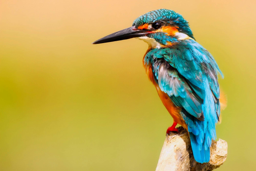

In [238]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

You can do it with whatever you want

Searching for 'happy karl marx'


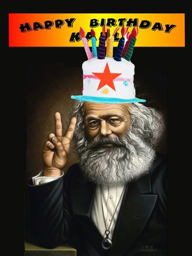

In [244]:
download_url(search_images('karl marx', max_images=1)[0], 'karl.jpg', show_progress=False)
Image.open('karl.jpg').to_thumb(256,256)

The objective will be to download a bunch of photos, and to use machine learning to recognize what's in the photos:

- The input we have is already labelled: for each of these pictures we know what they are picture of!
- We download about 200 photos

In [246]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


Remove the photos that were not properly downloaded

In [247]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

To train a model, we'll need DataLoaders, it contains:

- a training set - the images used to create a model)
- a validation set - the images used to check the accuracy of a model -- not used during training. 

In fastai we can create that easily using a DataBlock, and view sample images from it:

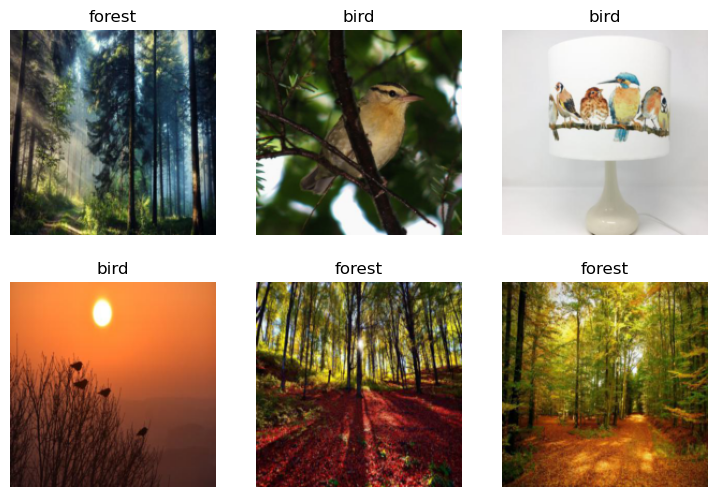

In [248]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we download the actual model.

- When we instantiate the model we:
    - Choose a data batch. So in this case the images we downloaded
    - A type of neural network, here we take their pretrained neural network
    - A method of evaluation: we want to minimize the error rate

In [249]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\anato/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:05<00:00, 8.76MB/s]


Let's try our model out!

In [254]:
is_bird,_,probs = learn.predict(PILImage.create('bird_or_not/forest/dea14596-ab35-492b-b03e-883c75378d2b.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


It's not working because it does not know yet what it needs to do. It's trained to see things but we haven't trained it to see birds and return information about bird or forest.

In [255]:
learn.fine_tune(3)

In [256]:
is_bird,_,probs = learn.predict(PILImage.create('bird_or_not/forest/dea14596-ab35-492b-b03e-883c75378d2b.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0000


That is it for Python for Economics!

## Well Done!

When you'll feel confortable with the concepts with treated in this class, you'll have abilities that only a very selected group of economists have.